## Simple example - Temperature Only Analysis
This notebook shows how to train model for temperature data only

In [1]:
# Imports
import sys
import matplotlib.pyplot as plt
import cartopy
import torch

sys.path.append('../src/')
from DatasetUS import *
from TrainDiffusion import *  # UNCOMMENTED - Now using Diffusion training
import Network  # Import Network module for EDMPrecond
# from TrainUnet import *  # COMMENTED OUT - Switching to Diffusion training



This example can be run on a laptop but won't train the network very well. We will train with just a small subset of data. 

In [2]:
## Select years to train and validate
train_year_start = 1953
train_year_end = 1955

valid_year_start = 1956
valid_year_end = 1957

Set up training hyperparameters. We will only run for 10 epochs and we will use the cpu. 

In [3]:
## Select hyperparameters of training
batch_size = 4  # Reduced from 16 to fit RTX 4050 (6GB VRAM)
learning_rate = 1e-4
accum = 8

# Run training for small number of epochs 
num_epochs = 2        

# Define device
# torch.cuda.set_device(0)  # Use GPU 1 as default
# device = 'cuda'  # Will use GPU 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# define the ml model - NOW USING DIFFUSION MODEL
# Note: EDMPrecond concatenates noisy image (1 channel) + conditional image (3 channels) = 4 channels total
diffusion_model = Network.EDMPrecond((256, 128), 4, 1, label_dim=2)  # UNCOMMENTED - Diffusion model (4 input channels)
diffusion_model.to(device)
# unet_model = UNet((256, 128), 3, 1, label_dim=2, use_diffuse=False)  # COMMENTED OUT - Switching to Diffusion

# define the datasets
datadir = "../data/"
dataset_train = UpscaleDataset(datadir, year_start=train_year_start, year_end=train_year_end,
                               constant_variables=["lsm", "z"])

dataset_test = UpscaleDataset(datadir, year_start=valid_year_start, year_end=valid_year_end,
                              constant_variables=["lsm", "z"])

dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)

Opening files
All files accessed. Creating tensors
Original data shape: torch.Size([720, 128, 256])
Weekly data shape: torch.Size([103, 128, 256]) (86% reduction)
Original time steps: 720
Weekly time steps: 103 (86% reduction)
torch.Size([1])
tensor([259.5524]) tensor([310.5276])
Opening constant variables file (e.g. land-sea mask, topography)
Normalize z
Mean:4599.7172769893, Std6220.847535033135
Dataset initialized.
Opening files
All files accessed. Creating tensors
Original data shape: torch.Size([360, 128, 256])
Weekly data shape: torch.Size([52, 128, 256]) (86% reduction)
Original time steps: 360
Weekly time steps: 52 (86% reduction)
torch.Size([1])
tensor([259.5524]) tensor([310.5276])
Opening constant variables file (e.g. land-sea mask, topography)
Normalize z
Mean:4599.7172769893, Std6220.847535033135
Dataset initialized.


In [4]:
print(len(dataloader_train), len(dataloader_test))

# Debug: Check the actual data shapes
batch = next(iter(dataloader_train))
print("Input shape:", batch["inputs"].shape)
print("Target shape:", batch["targets"].shape)
print("Expected input channels: 3 (1 temp + 2 constants)")
print("Actual input channels:", batch["inputs"].shape[1])
print("Model expects:", 4, "channels (1 noisy + 3 conditional)")

# Check what channels we actually have
print("\\nDataset configuration:")
print("- Temperature variables:", dataset_train.varnames)
print("- Number of temperature variables:", dataset_train.n_var)
print("- Constant variables:", ["lsm", "z"])
print("- Expected total channels:", dataset_train.n_var + 2, "(temp + constants)")

# DIFFUSION TRAINING INFO
print("\\nDiffusion Training Info:")
print("- image_input (conditional):", batch["inputs"].shape, "channels")
print("- image_output (target):", batch["targets"].shape, "channels")
print("- EDMPrecond will concatenate: 1 (noisy) + 3 (conditional) = 4 channels")
print("- UNet expects: 4 input channels")

# WEEKLY DATA SUBSAMPLING INFO
print("\\nWeekly Data Subsampling:")
print("- Original data: Daily (365 days/year)")
print("- Weekly data: Every 7th day (52 days/year)")
print("- Data reduction: 86% (365 → 52 days)")
print("- Expected training speed: 7x faster")
print("- Training samples (weekly):", (train_year_end - train_year_start + 1) * 52)
print("- Validation samples (weekly):", (valid_year_end - valid_year_start + 1) * 52)

26 13
Input shape: torch.Size([4, 3, 128, 256])
Target shape: torch.Size([4, 1, 128, 256])
Expected input channels: 3 (1 temp + 2 constants)
Actual input channels: 3
Model expects: 4 channels (1 noisy + 3 conditional)
\nDataset configuration:
- Temperature variables: ['temp']
- Number of temperature variables: 1
- Constant variables: ['lsm', 'z']
- Expected total channels: 3 (temp + constants)
\nDiffusion Training Info:
- image_input (conditional): torch.Size([4, 3, 128, 256]) channels
- image_output (target): torch.Size([4, 1, 128, 256]) channels
- EDMPrecond will concatenate: 1 (noisy) + 3 (conditional) = 4 channels
- UNet expects: 4 input channels
\nWeekly Data Subsampling:
- Original data: Daily (365 days/year)
- Weekly data: Every 7th day (52 days/year)
- Data reduction: 86% (365 → 52 days)
- Expected training speed: 7x faster
- Training samples (weekly): 156
- Validation samples (weekly): 104


In [5]:
# Clear GPU memory
torch.cuda.empty_cache()

# # Check GPU memory
# print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
# print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
# print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

scaler = torch.amp.GradScaler('cuda')  # Updated for newer PyTorch

# define the optimiser - NOW USING DIFFUSION MODEL
optimiser = torch.optim.AdamW(diffusion_model.parameters(), lr=learning_rate)  # UNCOMMENTED - Using Diffusion
# optimiser = torch.optim.AdamW(unet_model.parameters(), lr=learning_rate)  # COMMENTED OUT - Using Diffusion

# Define the tensorboard writer
writer = SummaryWriter("./runs_diffusion")  # UNCOMMENTED - Using Diffusion
# writer = SummaryWriter("./runs_unet")  # COMMENTED OUT - Using Diffusion

# define loss function - EDM Loss for Diffusion
loss_fn = EDMLoss()  # UNCOMMENTED - Using Diffusion
# loss_fn = torch.nn.MSELoss()  # COMMENTED OUT - Using Diffusion

# train the model
losses = []

C:\Users\khosl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Start the training loop using Diffusion framework with weekly data. The plots generated will show the coarse res, the predicted, and the truth for a few samples and for different variables. At the start of training the first two columns (coarse res and predicted) look similar. Towards the end of the training, the last two columns (predicted and truth) should look similar.

**Note**: Diffusion training uses iterative denoising (40 steps) for sampling, which is slower but produces higher quality results. 

Train :: Epoch: 0:   4%|▍         | 1/26 [00:02<01:10,  2.82s/it]c:\Users\khosl\Documents\GitHub\ClimateDiffuse-main\examples\../src\TrainDiffusion.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\khosl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Train :: Epoch: 0: 100%|██████████| 26/26 [05:29<00:00, 12.67s/it, Loss: 0.9752]


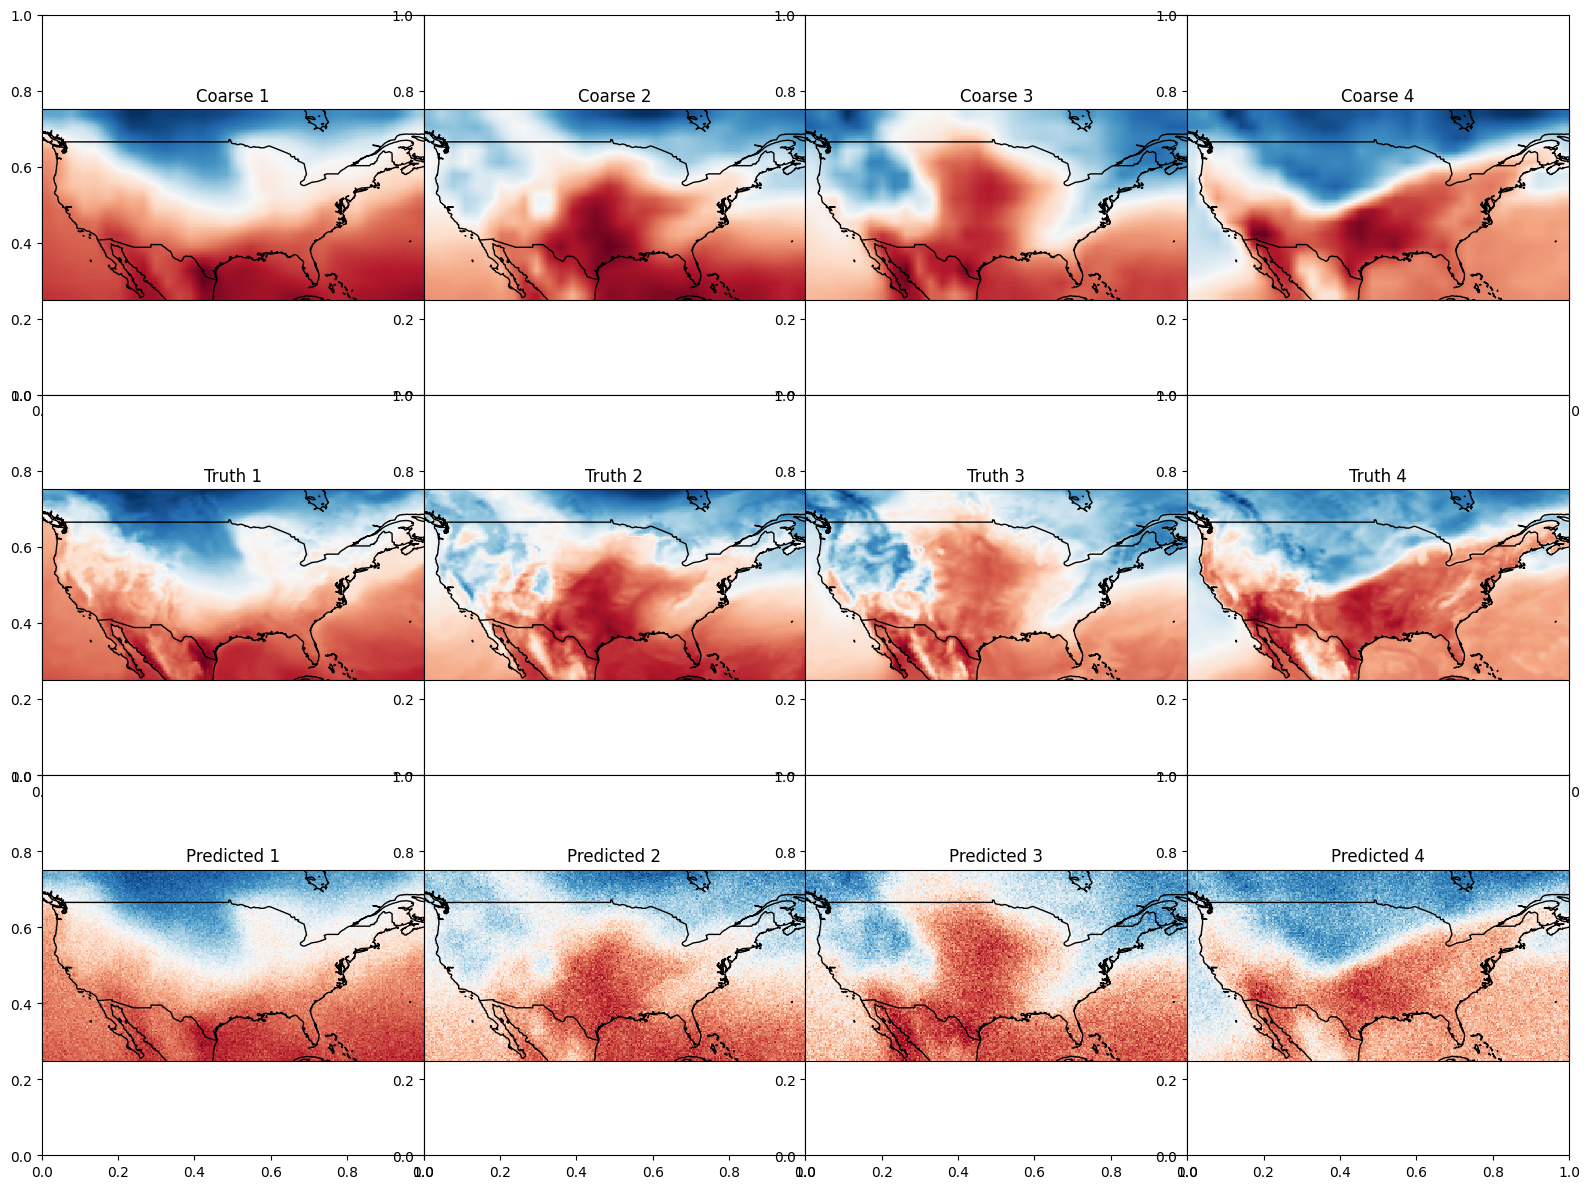

Train :: Epoch: 1:   4%|▍         | 1/26 [00:02<01:10,  2.83s/it]c:\Users\khosl\Documents\GitHub\ClimateDiffuse-main\examples\../src\TrainDiffusion.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\khosl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Train :: Epoch: 1: 100%|██████████| 26/26 [05:32<00:00, 12.79s/it, Loss: 0.9345]


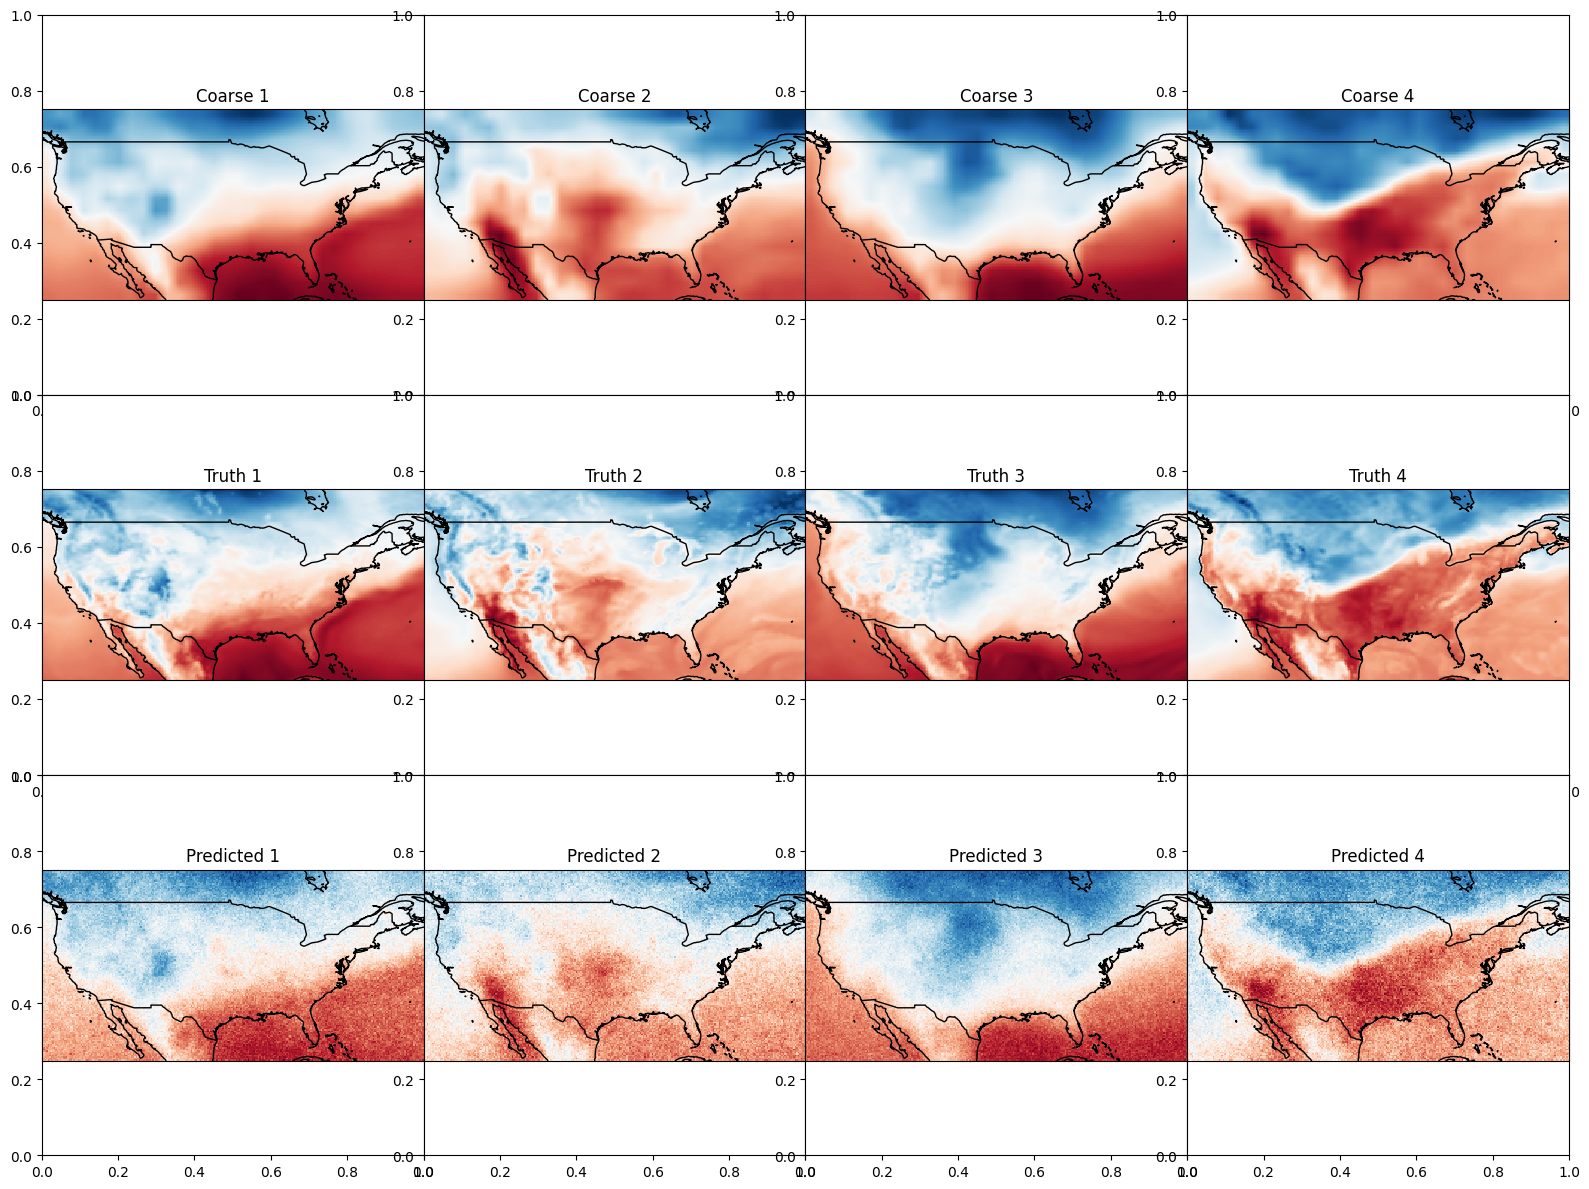

In [6]:
for step in range(num_epochs):
    # Clear GPU memory before each epoch
    torch.cuda.empty_cache()
    
    # Use Diffusion training step
    epoch_loss = training_step(
        diffusion_model, loss_fn, optimiser, dataloader_train, scaler, step,
        accum, writer, device=device)
    losses.append(epoch_loss)

    # Use Diffusion sampling (iterative denoising)
    (fig, ax), (base_error, pred_error) = sample_model(
        diffusion_model, dataloader_test, device=device)
    plt.show()

    writer.add_scalar("Error/base", base_error, step)
    writer.add_scalar("Error/pred", pred_error, step)
    
    # Clear memory after each epoch
    torch.cuda.empty_cache()
